In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

In [5]:
def gb_predict(X, trees_list, eta):

#     predictions = trees_list[0].predict(X)
    
#     for alg in trees_list[1:]:
#         predictions += eta * alg.predict(X)
        
#     predictions = trees_list[0].predict(X) + sum([eta*alg.predict(X) for alg in trees_list[1:]])

    predictions = sum([eta*alg.predict(X) for alg in trees_list])      
  
    return predictions

In [6]:
def mse(y, y_pred):
    return np.mean((y-y_pred)**2)

In [7]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    trees = []
    train_errors = []
    test_errors = []

    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        if len(trees) == 0:
            tree.fit(X_train, y_train)
            
        else:
            target = gb_predict(X_train, trees, eta)
            tree.fit(X_train, y_train-target)
        
        train_errors.append(mse(y_train, gb_predict(X_train, trees, eta)))
        test_errors.append(mse(y_test, gb_predict(X_test, trees, eta)))
        trees.append(tree)        
        
    return trees, train_errors, test_errors

In [8]:
def gb_fit2(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    trees = []
    predictions = np.zeros(X_train.shape[0])

    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        if len(trees) == 0:
            tree.fit(X_train, y_train)
        else:
            tree.fit(X_train, y_train - predictions)

        predictions += eta*tree.predict(X_train)
        trees.append(tree)
        
#     train_error = mse(y_train, predictions)
       
    return trees

In [9]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):
    train_prediction = gb_predict(X_train, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mse(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mse(y_test, test_prediction)}')

In [10]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [11]:
%%time

n_trees = 30
max_depth = 3
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 89 ms


In [12]:
%%time
trees = gb_fit2(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 26 ms


In [13]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)

Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 1751.7560700750466
Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3272.0915045213733


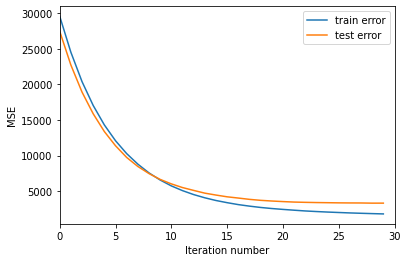

In [14]:
get_error_plot(n_trees, train_errors, test_errors)

In [15]:
md_list = range(1,5,1)
n_list = range(1,50,5)
eta = 0.1

In [16]:
train_er_all = []
test_er_all = []

for max_depth in md_list:
    train_errors = []
    test_errors = []
    
    for n_trees in n_list:
        trees = gb_fit2(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
        train_errors.append(mse(y_train, gb_predict(X_train, trees, eta)))
        test_errors.append(mse(y_test, gb_predict(X_test, trees, eta)))
        
    train_er_all.append(train_errors) 
    test_er_all.append(test_errors)    

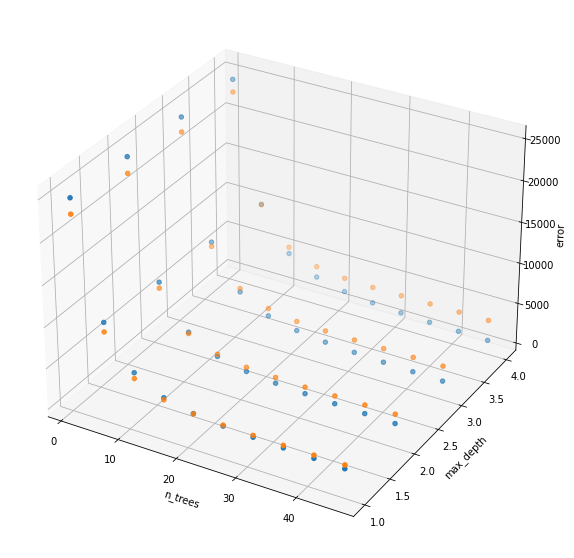

In [17]:
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
x, y = np.meshgrid(n_list, md_list)
ax.scatter(x, y, train_er_all)
# ax.contour3D(x, y, train_er_all, 100)
ax.scatter(x, y, test_er_all)

ax.set_xlabel('n_trees')
ax.set_ylabel('max_depth')
ax.set_zlabel('error')
plt.show()

In [18]:
test_er_all = np.array(test_er_all)
test_er_all.min()

3134.591386379179

In [19]:
i, j = np.where(test_er_all==test_er_all.min())

In [20]:
print(md_list[i[0]], n_list[j[0]])

1 41


Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [21]:
def gb_fit_stochastic(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    trees = []
    train_errors = []
    test_errors = []
    predictions = np.zeros(X_train.shape[0])
    predictions_t = np.zeros(X_test.shape[0])

    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        ind = np.random.randint(X_train.shape[0], size=X_train.shape[0]//2)

        if len(trees) == 0:
            tree.fit(X_train[ind], y_train[ind])
        else:
            tree.fit(X_train[ind], y_train[ind] - predictions[ind])

        train_errors.append(mse(y_train, predictions))
        test_errors.append(mse(y_test, predictions_t))
        
        predictions += eta*tree.predict(X_train)
        predictions_t += eta*tree.predict(X_test)
        
        trees.append(tree)          
        
    return trees, train_errors, test_errors

In [22]:
n_trees = 41
max_depth = 1
eta = 0.1

In [23]:
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

In [24]:
trees_st, train_errors_st, test_errors_st = gb_fit_stochastic(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

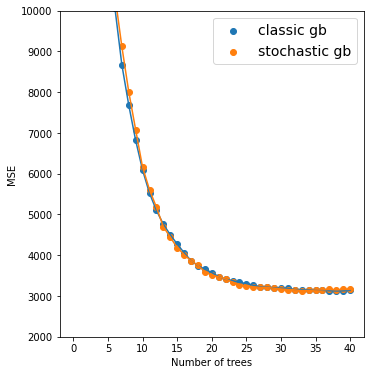

In [26]:
fig = plt.figure(figsize=(12, 6))
# plt.subplot(121)
# plt.scatter(range(len(train_errors)), train_errors, label='classic gb')
# plt.scatter(range(len(train_errors_st)), train_errors_st, label='stochastic gb')
# plt.xlabel('Number of trees')
# plt.ylabel('MSE')

plt.subplot(122)
plt.scatter(range(len(test_errors)), test_errors, label='classic gb')
plt.plot(range(len(test_errors)), test_errors)
plt.scatter(range(len(test_errors_st)), test_errors_st, label='stochastic gb')
plt.plot(range(len(test_errors_st)), test_errors_st)
plt.xlabel('Number of trees')
plt.ylabel('MSE')
plt.legend(fontsize=14)
plt.ylim(2000, 10000)

plt.show()

Когда размер подвыборки 0.3 и общее количество объектов в обучающей выборке 331, разницы между классическим и стохастическим бустингом почти не заметно...